In Class Exercises 11: Direct Simulation Monte Carlo (DSMC)

Driver: Robin Newby
Navigator: Matthew Hahn

In this exercise, we will be using the DSMC method to simulate Argon in the ideal gas regime.
You may make use of the dsmceq.py script to complete this exercise.

a) Simulate at least N = 3000 representative particles for 50 time-steps, generating a
histogram of their final speeds at the end of the run. Check to see if the system has
converged to the Maxwell-Boltzmann distribution by plotting the distribution curve
over the histogram (you may refer back to our random numbers exercise to find the
distribution function).



Each particle represents 8949.2  atoms
Plotting initial conditions. Close plots to continue.


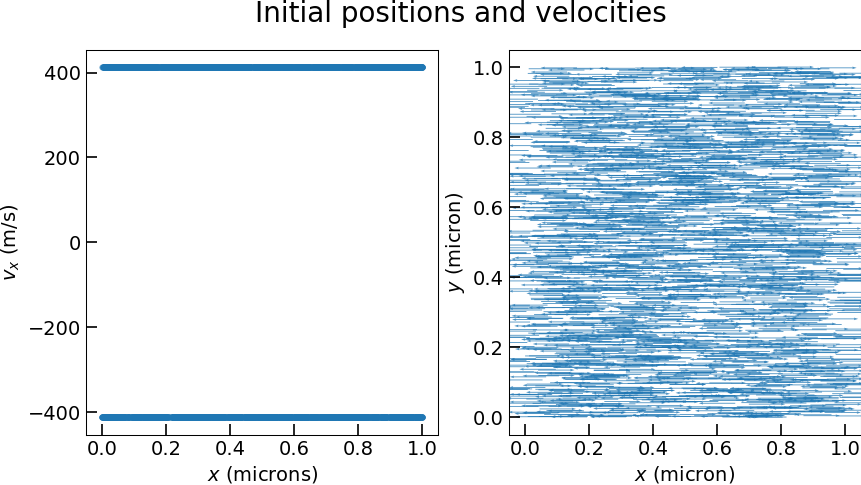

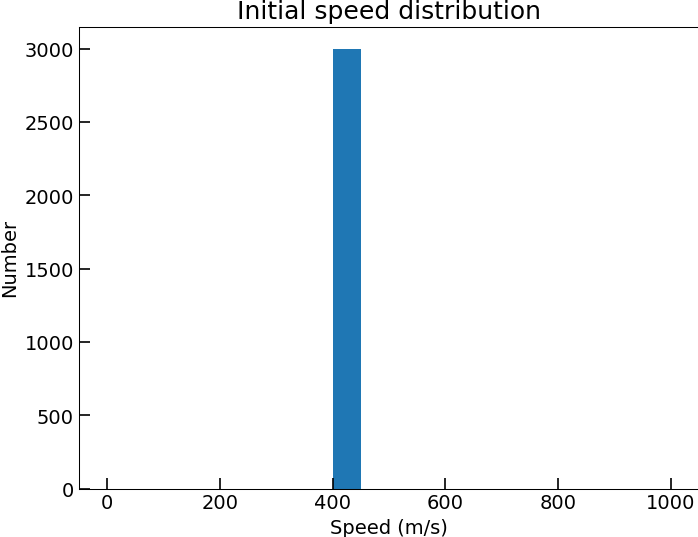

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


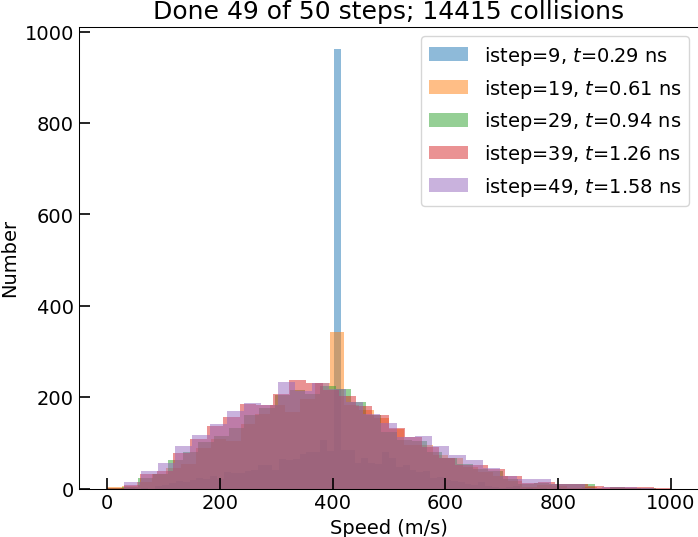

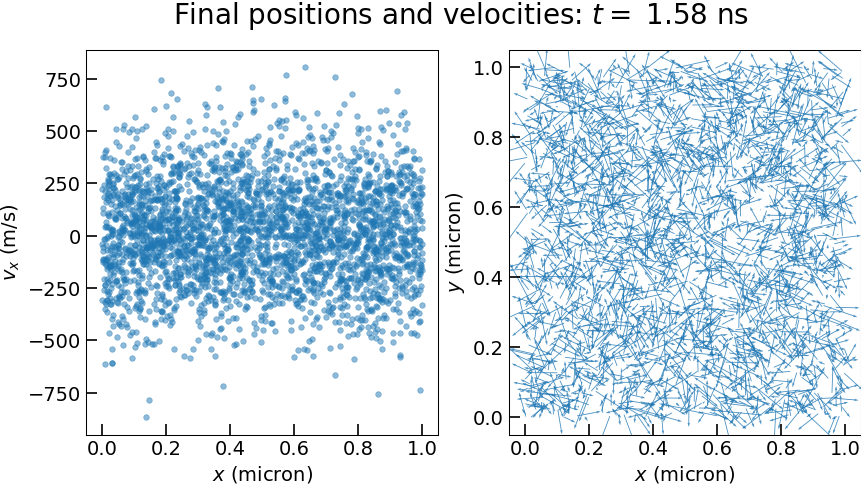

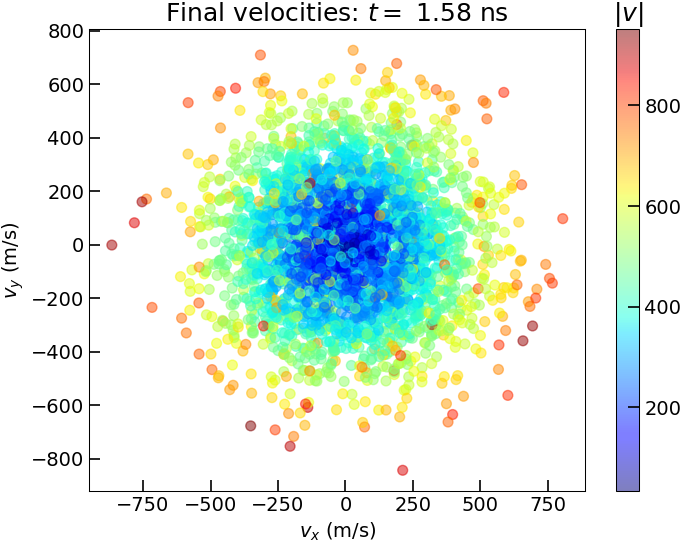

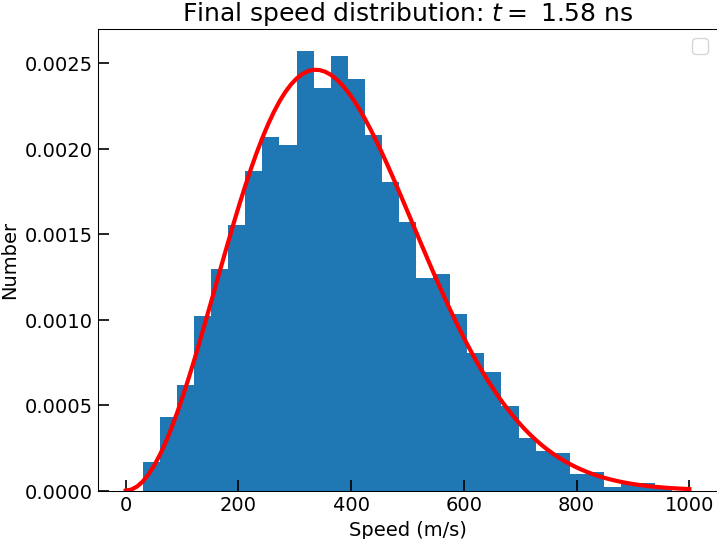

In [31]:
# dsmceq - Dilute gas simulation using DSMC algorithm. This version illustrates the approach to equilibrium.
# Original code by Garcia with modifications by Romanowsky & Hurst

# Set up configuration options and special features
import numpy as np
import matplotlib.pyplot as plt
from collider import collider

plt.style.use('matplotlibrc')  # This means that plots in this script will use the style parameters set in the rc file unless otherwise specified.
def maxwell_boltzmann(v, m, T):
    kb = 1.3806e-23  # set Boltzmann's constant to unity
    return 4*np.pi*(m/(2*np.pi*kb*T))**(3/2)*v**2*np.exp(-m*v**2/(2*kb*T))

# Set up input functions
def dinput(input_text) :
    return int(input(input_text))


def finput(input_text) :
    return float(input(input_text))


# Define classes for dealing with lists of particles
class sortList:
    """Class used for sorting particles into cells."""
    def __init__(self, ncell_in, npart_in):
        self.ncell = ncell_in
        self.npart = npart_in
        self.cell_n = np.zeros(ncell_in, dtype=int)
        self.index = np.empty(ncell_in, dtype=int)
        self.Xref = np.empty(npart_in, dtype=int)


class sampList:
    """Class used for sampling density, velocity, and temperature."""
    def __init__(self, ncell_in):
        self.ncell = ncell_in
        self.nsamp = 0
        self.ave_n = np.zeros(ncell_in)
        self.ave_u = np.zeros((ncell_in,3))
        self.ave_T = np.zeros(ncell_in)


def sorter(x,L,sD) :
    """sorter - Function to sort particles into cells
       Inputs
         x       Positions of particles
         L       System size
         sD      Object containing sorting lists
    """

    #* Find the cell address for each particle
    npart = sD.npart
    ncell = sD.ncell
    jx = np.empty(npart,dtype=int)
    for ipart in range(npart) :
        jx[ipart] = int(x[ipart]*ncell/L)
        jx[ipart] = min(jx[ipart], (ncell-1))

    #* Count the number of particles in each cell
    sD.cell_n = np.zeros(ncell)
    for ipart in range(npart):
        sD.cell_n[jx[ipart]] += 1

    #* Build index list as cumulative sum of the number of particles in each cell
    m = 0
    for jcell in range(ncell) :
        sD.index[jcell] = m
        m += sD.cell_n[jcell]

    #* Build cross-reference list
    temp = np.zeros(ncell, dtype=int)      # Temporary array
    for ipart in range(npart) :
        jcell = jx[ipart]       # Cell address of ipart
        k = sD.index[jcell] + temp[jcell]
        sD.Xref[k] = ipart
        temp[jcell] += 1


#* Initialize constants  (particle mass, diameter, etc.)
boltz = 1.3806e-23     # Boltzmann's constant (J/K)
mass = 6.63e-26        # Mass of argon atom (kg)
diam = 3.66e-10        # Effective diameter of argon atom (m)
T = 273                # Temperature (K)
density = 1.78         # Density of argon at STP (kg/m^3)
L = 1e-6               # System size is one micron
npart = 3000#dinput('Enter number of simulation particles: ')
eff_num = density/mass * L**3 /npart
print('Each particle represents %.1f  atoms' % eff_num)


#* Assign random positions and velocities to particles
np.random.seed(0)          # Initialize random number generator
# x = np.empty(npart)
x = np.random.random(npart) * L           # Assign random positions
v_init = np.sqrt(3*boltz*T/mass)      # Initial speed in m/s
v = np.zeros((npart,3))  # Initialize vector of 3D velocities. First dimension is the number of particles, second dimension 3 for x, y, z.
v[:,0] = v_init * (1 - 2 * np.floor(2*np.random.random(npart)))  # Initially, only x-component of velocity is non-zero

# Plot initial positions and velocities
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig1.suptitle('Initial positions and velocities')
ax1[0].plot(x/1e-6,v[:,0],'o',ms=4,alpha=0.5)
ax1[0].set_xlabel('$x$ (microns)')
ax1[0].set_ylabel('$v_x$ (m/s)')

ax1[1].quiver(x/1e-6, np.random.random(npart)*L/1e-6,v[:,0],v[:,1],scale_units='width',scale=4000,alpha=0.8,color='C0')
ax1[1].set_xlabel('$x$ (micron)')
ax1[1].set_ylabel('$y$ (micron)')

# Plot the initial speed distribution
fig3, ax3 = plt.subplots(figsize=(8,6))
vmag = np.linalg.norm(v, axis=1)  # find the magnitude of the velocity.
ax3.hist(vmag, bins=20, range=(0,1000))
ax3.set_title('Initial speed distribution')
ax3.set_xlabel('Speed (m/s)')
ax3.set_ylabel('Number')

print('Plotting initial conditions. Close plots to continue.')
plt.show()

#* Initialize variables used for evaluating collisions
ncell = 15                      # Number of cells
dt = 0.2*(L/ncell)/v_init      # Set timestep dt
vrmax = 3*v_init*np.ones(ncell)    # Estimated max rel. speed
selxtra = np.zeros(ncell)          # Used by routine "collider"
coeff = 0.5*eff_num*np.pi*diam**2*dt/(L**3/ncell)
coltot = 0                      # Count total collisions

# Declare sortList object for lists - used in sorting
sortData = sortList(ncell, npart)

############# MAIN LOOP ##################################
# * Loop for the desired number of time steps
nstep = 50#dinput('Enter total number of time steps: ')
vrec=np.zeros((nstep,npart,3))
fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.tick_params('both', length=8, width=1.2, which='major')

# bigger axis ticks
for istep in range(nstep):

    # * Move all the particles ballistically
    x = x + v[:, 0] * dt  # Update x position of particle
    x = np.remainder(x + L, L)  # This line implements periodic boundary conditions

    # * Sort the particles into cells
    sorter(x, L, sortData)

    # * Evaluate collisions among the particles using acceptance-rejection
    col = collider(v, vrmax, dt, selxtra, coeff, sortData)
    coltot += col
    vrec[istep,:,:]=np.copy(v)
    # * Periodically display the current progress
    if (istep + 1) % 10 < 1:
        # vmag = sqrt( v[:,0]**2 + v[:,1]**2 + v[:,2]**2 )
        vmag = np.linalg.norm(v, axis=1)
        # hist( vmag, bins=11, range=(0,1000), alpha=0.5, label='istep=%d' % istep)
        ax4.hist(vmag, bins='auto', range=(0, 1000), alpha=0.5, label='istep=%d, $t$=%.2f ns' % (istep, istep * dt / 1e-9))
        ax4.set_title('Done %d of %d steps; %d collisions' % (istep, nstep, coltot))
        ax4.set_xlabel('Speed (m/s)')
        ax4.set_ylabel('Number')
        ax4.legend(loc='best')
ifinal = nstep-1
vmagfinal = np.linalg.norm(v, axis=1)
# plt.show()

fig5, ax5 = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
# fig5.gca().set_aspect('equal')
fig5.suptitle('Final positions and velocities: $t =$ %.2f ns' % (ifinal*dt/1e-9))
ax5[0].plot(x/1e-6,v[:,0],'o',ms=4,alpha=0.5)
ax5[0].set_xlabel('$x$ (micron)')
ax5[0].set_ylabel('$v_x$ (m/s)')
ax5[1].quiver(x/1e-6,np.random.random(npart),v[:,0],v[:,1],scale_units='width',scale=6000,alpha=0.8,color='C0')
ax5[1].set_xlabel('$x$ (micron)')
ax5[1].set_ylabel('$y$ (micron)')

fig6, ax6 = plt.subplots(figsize=(8, 6))
f6 = ax6.scatter(v[:,0],v[:,1],s=50,c=np.linalg.norm(v,axis=1),alpha=0.5,cmap='jet') # color-coded by |v|
cbar = fig6.colorbar(f6)
cbar.ax.set_title(r'$|v|$')
ax6.set_title('Final velocities: $t =$ %.2f ns' % (ifinal*dt/1e-9))
ax6.set_xlabel('$v_x$ (m/s)')
ax6.set_ylabel('$v_y$ (m/s)')


xvals=np.linspace(start=0,stop=1000,num=100)

maxwells=maxwell_boltzmann(xvals,mass,T)


fig7, ax7 = plt.subplots(figsize=(8, 6))
ax7.hist(vmagfinal, bins='auto', range=(0, 1000),density=True)
ax7.plot(xvals,maxwells,color='r',linewidth=3)
ax7.set_title('Final speed distribution: $t =$ %.2f ns' % (ifinal*dt/1e-9))
ax7.set_xlabel('Speed (m/s)')
ax7.set_ylabel('Number')
ax7.legend()
plt.show()

Looks good.

b) Add a 3D plot of the final particle velocities v = (vx, vy, vz ). Refer to the Matplotlib
documentation for plotting in 3D.


Text(0.5, 0, '$v_z$')

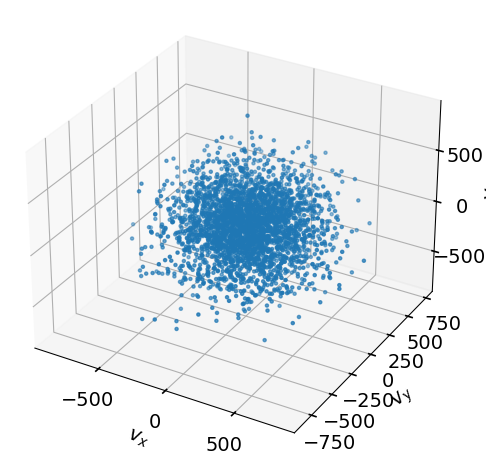

In [32]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
vx=v[:,0]
vy=v[:,1]
vz=v[:,2]
ax.scatter(vx, vy, vz, marker='.')
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')
ax.set_zlabel('$v_z$')

Looks spherical enough.

c) Compute and plot the average quantities vs. time, all on the same plot: Total speed
|v|, |vx|, |vy|, and |vz |.


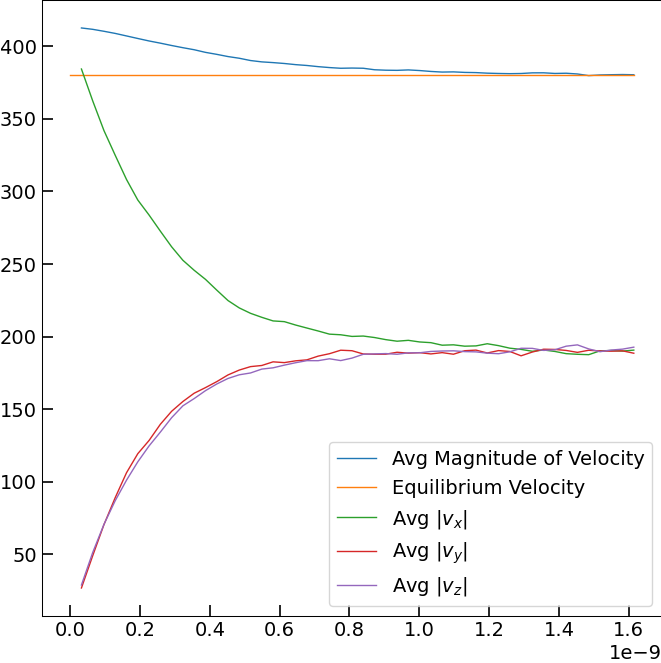

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
taxis=dt*(range(nstep))+dt
vrec
vmags=np.mean(np.linalg.norm(vrec, axis=2),1)
ax.plot(taxis,vmags,label='Avg Magnitude of Velocity')
equil_vel=2*np.sqrt(2*boltz*T/(np.pi*mass))

ax.plot(np.array([0,max(taxis)]),np.ones(2)*equil_vel,label='Equilibrium Velocity')


avg_vx=np.mean(np.abs(vrec[:,:,0]),1)
avg_vy=np.mean(np.abs(vrec[:,:,1]),1)
avg_vz=np.mean(np.abs(vrec[:,:,2]),1)
ax.plot(taxis,avg_vx,label='Avg |$v_x$|')
ax.plot(taxis,avg_vy,label='Avg |$v_y$|')
ax.plot(taxis,avg_vz,label='Avg |$v_z$|')


ax.legend(loc='best')

Looks good! The avg magnitude of velocity eaches equilibrium, and hte components quickly thermalize- each degree of freedom gets equal energy in the end, even when it all started in the x component of velocity.

Challenge question: Modify dsmceq.py to compute the entropy ‘H-function’ H(t), defined as
$$H= \sum_{bins} \Delta v \frac{N_h(v)}{N}ln(\frac{N_h(v)}{N})$$

Plot H(t) versus time and show that for a system initially out of equilibrium, H(t) decreases with time until the system equilibrates. What is the equilibrium value of H?

C:\Users\Robin\AppData\Local\Temp\ipykernel_1440\899761038.py:16: RuntimeWarning: divide by zero encountered in log
  Ent[tim]=np.sum(dv*density*np.log(density))
C:\Users\Robin\AppData\Local\Temp\ipykernel_1440\899761038.py:16: RuntimeWarning: invalid value encountered in multiply
  Ent[tim]=np.sum(dv*density*np.log(density))


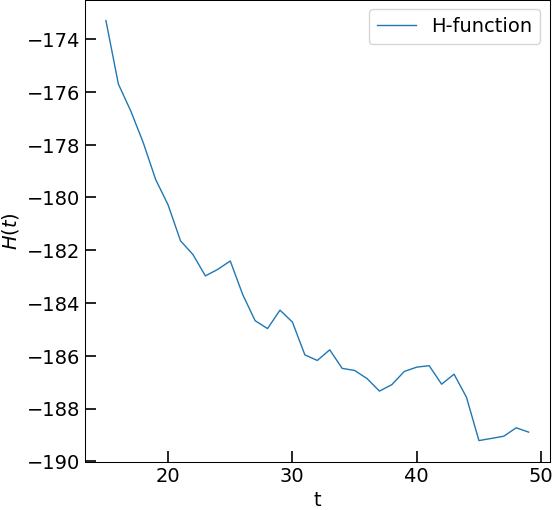

In [36]:
def Entropy(v,dv,plot=False):
    vmags=np.linalg.norm(v, axis=2)
    Ent=np.zeros(nstep)

    for tim in range(nstep):
        numBins=int(np.ceil(np.max(vmags[nstep-1,:])/dv))
        density=np.zeros(numBins)
        for bin in range(numBins):
            bin_low_bound=(bin)*dv
            bin_high_bound=(bin+1)*dv
            count=0
            for particle in range(npart):
                if vmags[tim,particle] >bin_low_bound and vmags[tim,particle] < bin_high_bound:
                    count=count+1
            density[bin]=count/npart
        Ent[tim]=np.sum(dv*density*np.log(density))
    return Ent
plt.figure(figsize=(6,6))
plt.plot(range(nstep),Entropy(vrec,100),label='H-function')
plt.xlabel('t')
plt.ylabel('$H(t)$')
plt.legend()






This looks pretty reasonable, and overall I think it's pretty good. Sure, none of the code is vectorized as that was causing some brain-melting, but it runs decently fast despite the 3 nested loops. There may be some issues with zeros getting passed to the log function, but for dv equal to 10 it largely functions. It looks like the H-function equilibrates approximately at -189 or so.
